In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from diffusion_and_model import Diffusion_without_class,sample,p_losses
from torch import nn, einsum, optim
import torch
import tqdm
import os
# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline
timesteps =1000

In [2]:
model = Diffusion_without_class()

In [3]:

train_image = np.load("cifar10_train_image.npy")
train_label = np.load("cifar10_train_label.npy")
image_1000 = np.array(train_image[:1000])
labels_1000 =np.array(train_label[:1000])


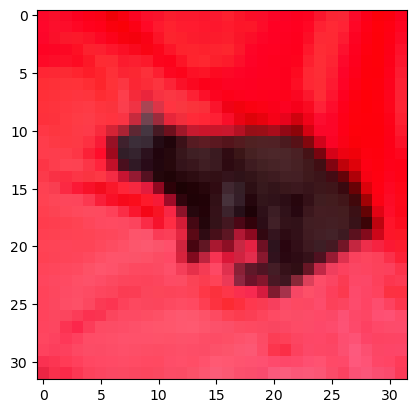

In [5]:

source = torch.tensor(image_1000[21:22].transpose([0,3,1,2]).astype(np.float32)/255)
plt.imshow(source[0].numpy().transpose(1,2,0))

In [6]:
model.load_state_dict(torch.load('cifar10_diffusion_without_class_model_epoch_10000_dataset_1000_sample_1000_time.pth'))

<All keys matched successfully>

torch.Size([1, 3, 32, 32])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000
torch.Size([1, 3, 32, 32])


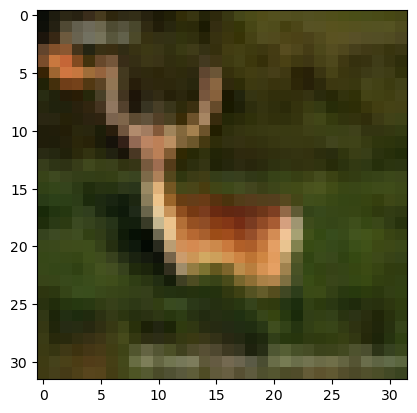

In [7]:
samples = sample(model, image_size=32, batch_size=1, channels=3)

# Get the last sample and normalize it in [0,1]
# last_sample = (samples[-1] - samples[-1].min())/(samples[-1].max()-samples[-1].min())
last_sample = samples[-1]
print(len(samples))
print(last_sample.shape)
plt.imshow((last_sample[0].numpy().transpose(1,2,0)+1.0)/2.0)

In [25]:
class generalized_inverse(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpool2d = nn.AvgPool2d(4)
        self.upsample = nn.Upsample(scale_factor=4)
        self.color2gray =  torch.tensor([1/3.0, 1/3.0, 1/3.0], requires_grad=False, dtype=torch.float32).reshape(
            1, 3).to("cuda")
        self.gray2color = torch.tensor([1.0, 1.0,1.0], requires_grad=False, dtype=torch.float32).reshape(
            3, 1).to("cuda")


#         self.w = nn.parameter.Parameter(torch.zeros((2,1000)))
        self.w = nn.parameter.Parameter(torch.zeros((1,3,32,32)))
 
    def forward(self,Pan,Ms):
        #B`Z + (Y-B`ZA)A` +(I-B`B)W(I-AA`)
 
        Bg_iZ=self.upsample(Ms)

        Bg_iZA = einsum('n m, k m w h -> k n w h', self.color2gray, Bg_iZ)

        Y_Bg_iZAAg_i = einsum('m n, k n w h -> k m w h',self.gray2color, Pan-Bg_iZA)
        
        Bg_iBW = self.upsample(self.avgpool2d(self.w))
        W_Bg_iBW = self.w - Bg_iBW
        
        AAg_i = einsum('n m, m c -> n c',self.gray2color , self.color2gray)
        
        W_Bg_iBW_AAg_i=einsum('n m, k n w h -> k m w h', AAg_i, W_Bg_iBW)
        return Bg_iZ + Y_Bg_iZAAg_i +W_Bg_iBW - W_Bg_iBW_AAg_i

    def direct(self,Pan,MS):
        #B`Z + (Y-B`ZA)A` 
        Bg_iZ=self.upsample(Ms)
        Bg_iZA = einsum('n m, k m w h -> k n w h', self.color2gray, Bg_iZ)
        Y_Bg_iZAAg_i = einsum('m n, k n w h -> k m w h',self.gray2color, Pan-Bg_iZA)
        return Bg_iZ + Y_Bg_iZAAg_i
    def test(self):
        return torch.sum(self.w)
    def A_(self,source):

        Pan = einsum('n m, k m w h -> k n w h',self.color2gray, source)
        Ms = self.avgpool2d(source)
        return Pan, Ms


In [42]:
for index in range(4):
    source = torch.tensor(image_1000[20+index:21+index].transpose([0,3,1,2]).astype(np.float32)/255)
    device = "cuda"
    model=model.to(device)
    g_i =  generalized_inverse()
    g_i = g_i.to("cuda")
    source = source.to("cuda")
    Pan, Ms=g_i.A_(source)
    Pan=Pan.to("cuda")
    Ms = Ms.to("cuda")
    print("pan shape",Pan.shape)
    print("ms shape",Ms.shape)
    if not os.path.exists(r"figure\images_pansharpening\PCS"):
        os.makedirs( r"figure\images_pansharpening\PCS")
    file_name = r"figure\images_pansharpening\PCS\{0}_recover.png".format(index)
    signalx=g_i.direct(Pan,Ms)
    plt.imsave(file_name,np.clip(signalx[0].cpu().detach().numpy().transpose(1,2,0),0,1))
    if not os.path.exists(r"figure\images_pansharpening\origin"):
        os.makedirs( r"figure\images_pansharpening\origin")
    file_name = r"figure\images_pansharpening\origin\{0}_origin.png".format(index)
    plt.imsave(file_name,source[0].cpu().numpy().transpose(1,2,0))
    
    opt_sgd = optim.SGD(g_i.parameters(), lr=1)
    scaler = torch.cuda.amp.GradScaler()
    #for p in model.parameters():
    #    p.requires_grad = False
    def train_generalized_inverse():
        iteration = 20001
        for i in range(iteration):

            opt_sgd.zero_grad()

            # Evaluate the loss
            #loss = g_i.loss(y)

            signal_x=g_i(Pan,Ms)
            t = torch.randint(0, timesteps, (1,), device="cuda").long()

            loss_diffusion = p_losses(model, signal_x*2-1, t)

            scaler.scale(loss_diffusion).backward()
            scaler.step(opt_sgd)

            scaler.update()
            if i%1000==0:
                print(f' iteration: {i}, loss: {loss_diffusion.item():g}')
    train_generalized_inverse()

    if not os.path.exists(r"figure\images_pansharpening\ours"):
        os.makedirs( r"figure\images_pansharpening\ours")
    file_name = r"figure\images_pansharpening\ours\{0}_recover.png".format(index)

    signal_x=g_i(Pan,Ms)
    plt.imsave(file_name,np.clip(signal_x[0].cpu().detach().numpy().transpose([1,2,0]),0,1))
    
    file_name = r"figure\images_pansharpening\origin\{0}_pan.png".format(index)

    plt.imsave(file_name,Pan[0,0].cpu().detach().numpy(),cmap='gray')
    
    file_name = r"figure\images_pansharpening\origin\{0}_ms.png".format(index)

    plt.imsave(file_name,Ms[0].cpu().detach().numpy().transpose([1,2,0]),cmap='gray')
    # RMSE
    print("index {0} our mse".format(index), np.sqrt(np.mean((source[0].cpu().numpy()-signal_x[0].cpu().detach().numpy())**2)))
    
    #color consistency
    print("index {0} our color consistency".format(index),np.sqrt(np.mean(((nn.AvgPool2d(4)(signal_x))[0].cpu().detach().numpy()-Ms[0].cpu().detach().numpy())**2)))
    
    #spatial consistency
    color2gray=torch.tensor([1/3.0, 1/3.0, 1/3.0], requires_grad=False, dtype=torch.float32).reshape(
                1, 3).to("cuda")
    print("index {0} our spatial consistency".format(index),np.sqrt(np.mean((einsum('n m, k m w h -> k n w h',color2gray, signal_x)[0,0].cpu().detach().numpy()-Pan[0,0].cpu().detach().numpy())**2)))
          
    #PCS
    signalx=g_i.direct(Pan,Ms)
          
    # RMSE
    print("index {0} PCS mse".format(index),np.sqrt(np.mean((signalx[0].cpu().numpy()-signal_x[0].cpu().detach().numpy())**2)))
          
    #color consistency
    print("index {0} PCS color consistency".format(index),np.sqrt(np.mean(((nn.AvgPool2d(4)(signalx))[0].cpu().detach().numpy()-Ms[0].cpu().detach().numpy())**2)))
    
          
    #spatial consistency
    color2gray=torch.tensor([1/3.0, 1/3.0, 1/3.0], requires_grad=False, dtype=torch.float32).reshape(
                1, 3).to("cuda")
    print("index {0} PCS spatial consistency".format(index),np.sqrt(np.mean((einsum('n m, k m w h -> k n w h',color2gray, signalx)[0,0].cpu().detach().numpy()-Pan[0,0].cpu().detach().numpy())**2)))

pan shape torch.Size([1, 1, 32, 32])
ms shape torch.Size([1, 3, 8, 8])
 iteration: 0, loss: 0.00119252
 iteration: 1000, loss: 5.83004e-05
 iteration: 2000, loss: 0.000303145
 iteration: 3000, loss: 0.000501771
 iteration: 4000, loss: 0.000321376
 iteration: 5000, loss: 0.00179623
 iteration: 6000, loss: 0.00202464
 iteration: 7000, loss: 0.0107065
 iteration: 8000, loss: 0.000818201
 iteration: 9000, loss: 0.0121048
 iteration: 10000, loss: 0.00072478
 iteration: 11000, loss: 0.000406982
 iteration: 12000, loss: 0.000633178
 iteration: 13000, loss: 0.00470869
 iteration: 14000, loss: 0.00010877
 iteration: 15000, loss: 0.000723642
 iteration: 16000, loss: 0.00682733
 iteration: 17000, loss: 0.0106952
 iteration: 18000, loss: 0.000372118
 iteration: 19000, loss: 0.000141744
 iteration: 20000, loss: 0.00193437
index 0 our mse 0.0077850814
index 0 our color consistency 6.00685e-08
index 0 our spatial consistency 3.1658118e-08
index 0 PCS mse 0.011610964
index 0 PCS color consistency 6.07

4.2167745e-08

2.4229493e-08